# Billboard Exploratory Data Analysis
In this notebook, we focus on exploring the data from only the Billboard Year-end Top 100 charts.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

from matplotlib import rcParams
from matplotlib.patches import Rectangle
from scipy.stats import relfreq

sns.set(context='poster', style='white')
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = 'arial'

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

## Load data
Load data scraped, cleaned, and combined in previous 3 notebooks.

In [2]:
df_billboard = pd.read_csv('../data/processed/billboard.csv')
df_billboard.sample(10)

,year,rank,song,main_artist,featuring_artist,other_artist
107,1961,8,wheels,the string a longs,NaN,NaN
3092,1990,92,forever,kiss,NaN,NaN
5031,2010,31,say aah,trey songz,fabolous,NaN
4880,2008,80,womanizer,britney spears,NaN,NaN
5514,2015,14,take me to church,hozier,NaN,NaN
4843,2008,43,a milli,lil wayne,NaN,NaN
2361,1983,61,how am i supposed to live without you,laura branigan,NaN,NaN
4523,2005,23,drop it like its hot,snoop dogg,pharrell,NaN
5174,2011,74,back to december,taylor swift,NaN,NaN
717,1967,18,expressway to your heart,the soul survivors,NaN,NaN


## Most popular artists

Text(32.5, 1, 'Billboard Year-End\nHot 100 1960-2019')

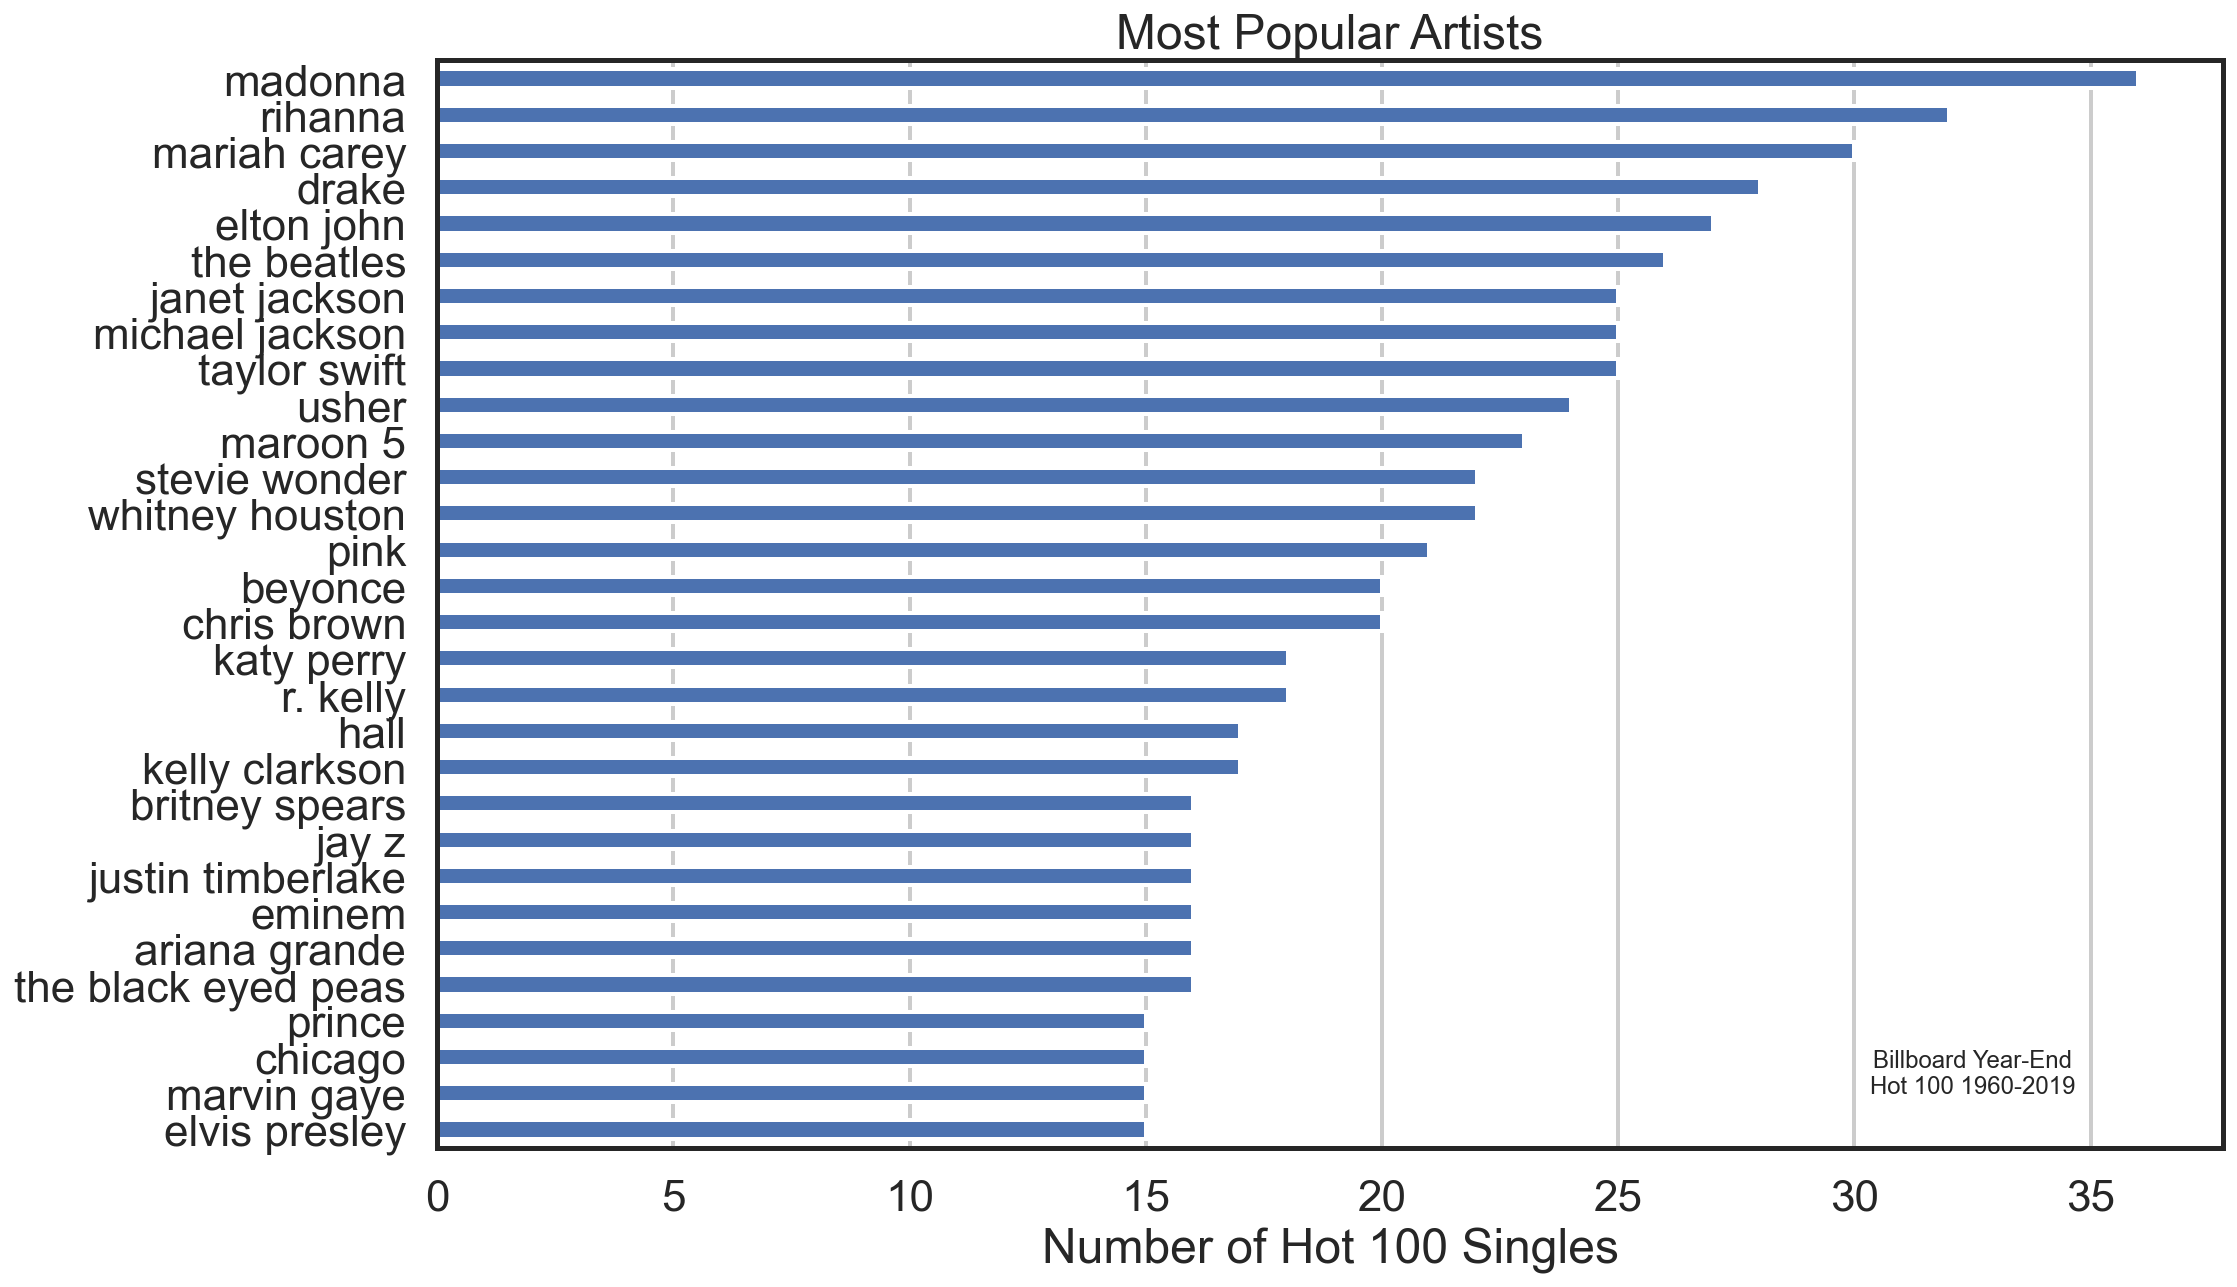

In [3]:
ax = df_billboard['main_artist'].value_counts().sort_values().tail(30).plot.barh(figsize=(16,10))
ax.xaxis.grid(True)
ax.set(xlabel='Number of Hot 100 Singles')
ax.set_title('Most Popular Artists', fontsize=24)
ax.annotate('Billboard Year-End\nHot 100 1960-2019', xy=(32.5,1), fontsize=12, ha='center')

## Artist diversity over time

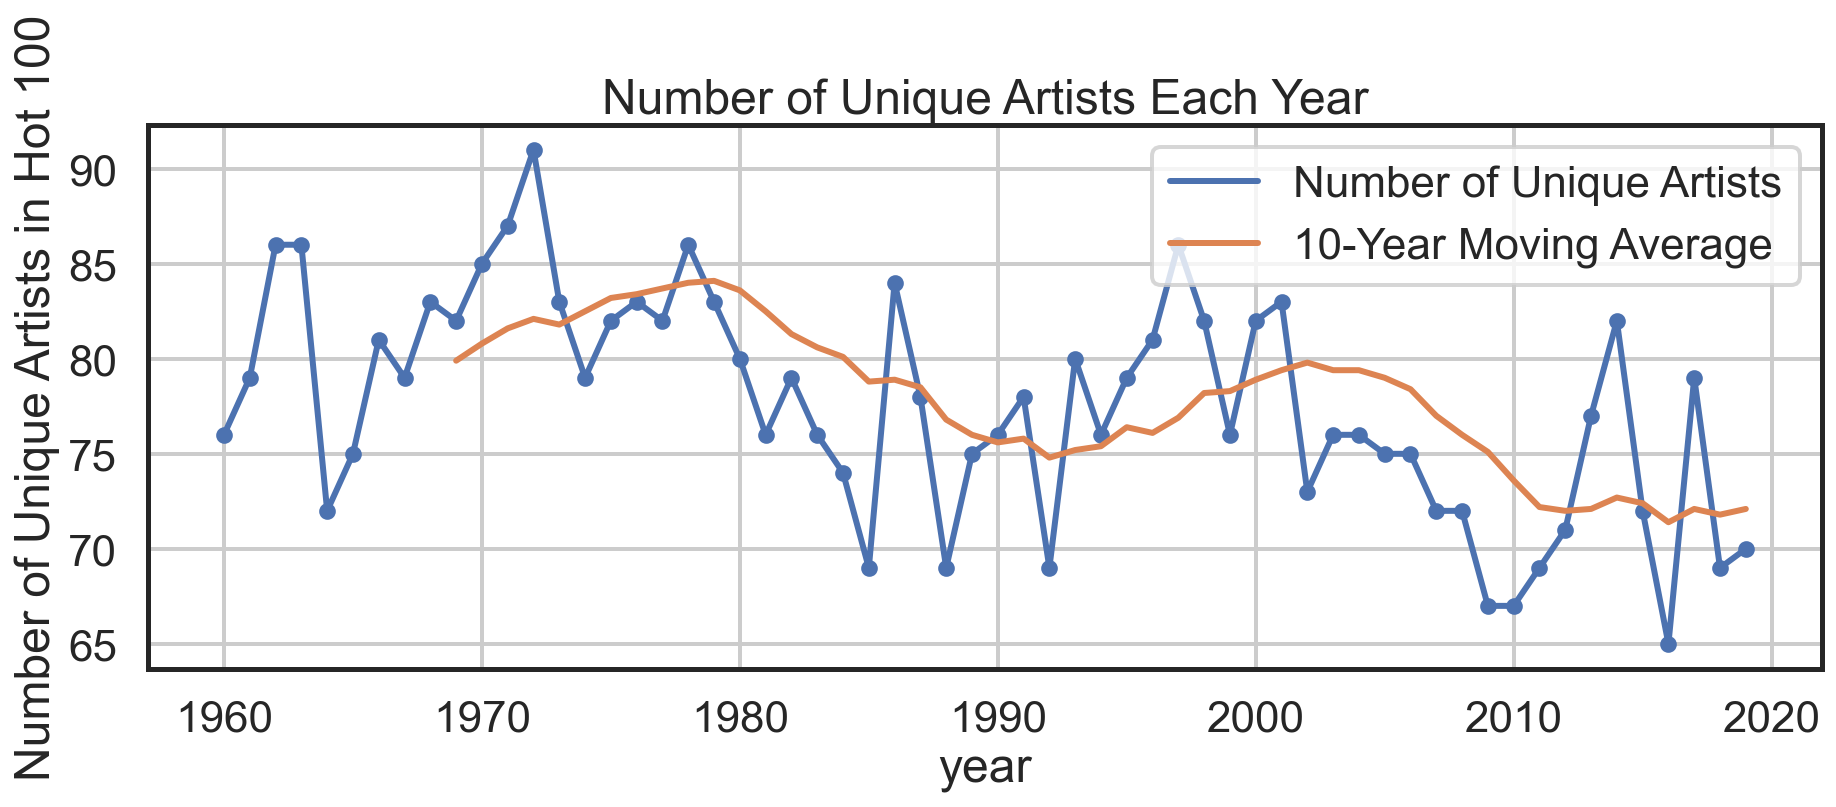

In [4]:
# calculate number of unique artists for each year
nunique_artists_year = df_billboard.groupby(['year'])['main_artist'].agg(pd.Series.nunique)

# generate line plot and augment with points
ax = nunique_artists_year.plot.line(figsize = (15,5), grid=True, label='# unique artists')
ax.scatter(nunique_artists_year.index, nunique_artists_year, s=40)
ax.set(ylabel='Number of Unique Artists in Hot 100',
       title='Number of Unique Artists Each Year')

# denoise with a 10-year moving average
nunique_artists_year.rolling(window=10).mean().plot(
    grid=True, label='10-year moving average')
ax.annotate('Billboard Year-End\nHot 100 1960-2019', xy=(1965,61),
            fontsize=12, ha='center')
plt.legend(['Number of Unique Artists', '10-Year Moving Average']);

## Artist collaboration over time

Text(1962, 1.5, 'Billboard Year-End\nHot 100 1960-2019')

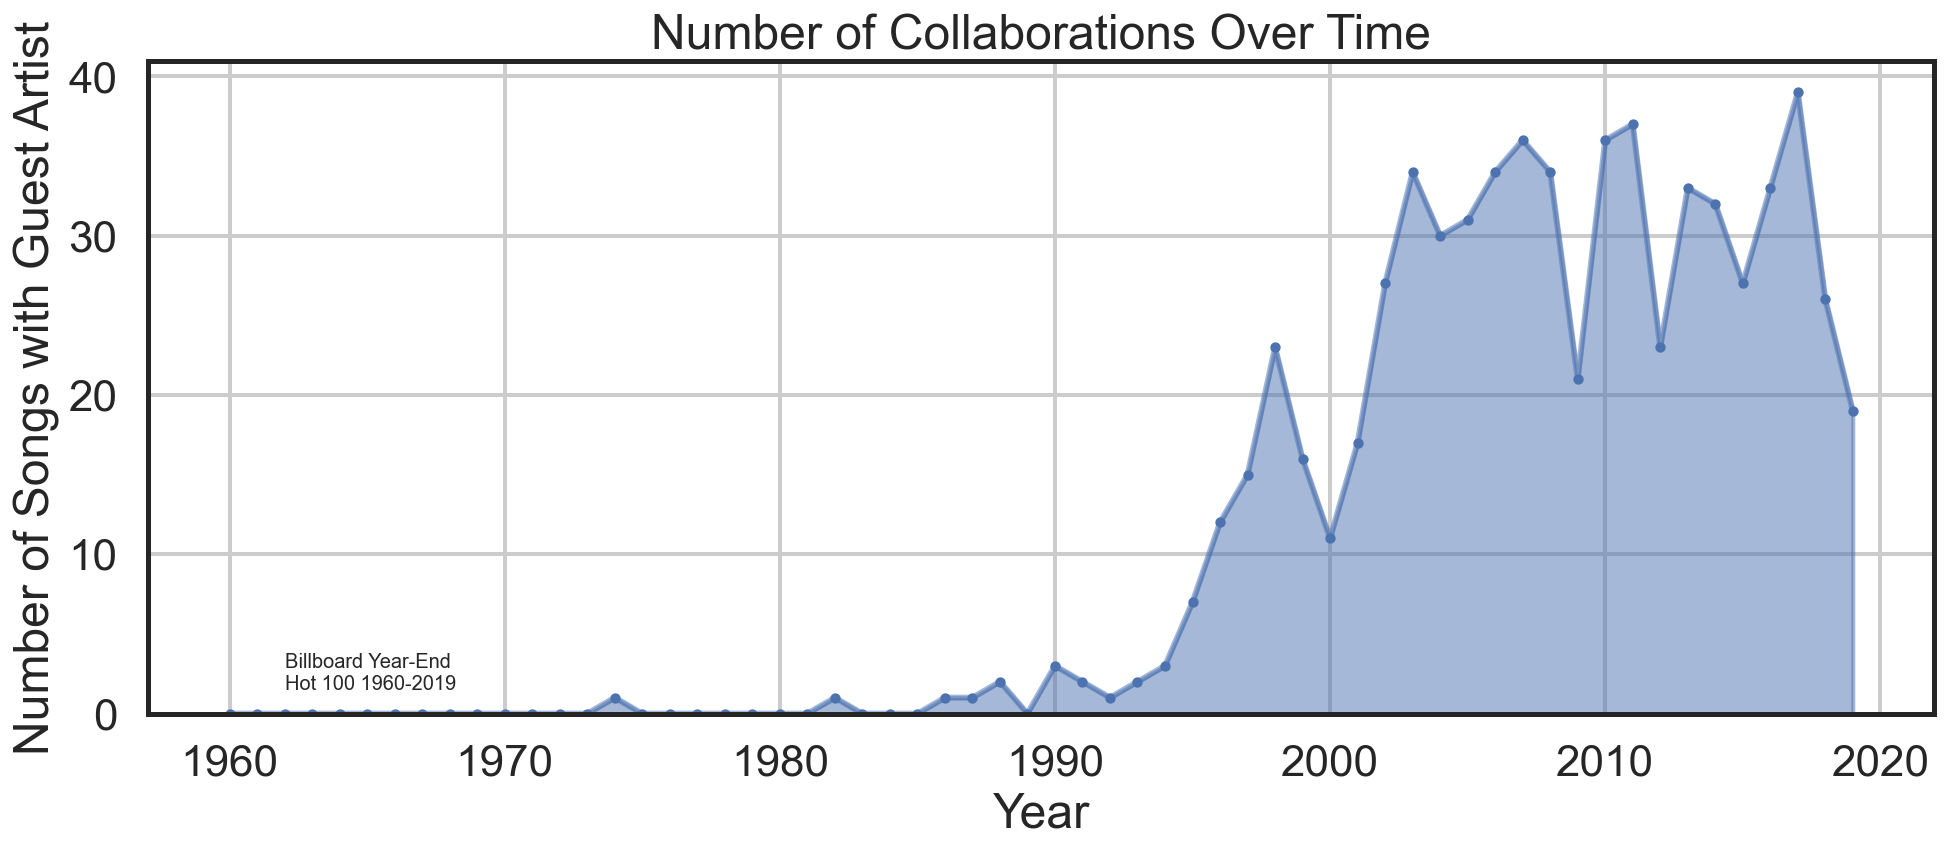

In [5]:
# collaboration counted if artist name contains "featuring"
df_collab = df_billboard[df_billboard['featuring_artist'].notnull()]
df_collab = df_collab.groupby(['year'])['featuring_artist'].count().reindex(range(1960, 2020))
df_collab = df_collab.fillna(0)

# generate line plot and augment with points
ax = df_collab.plot.area(figsize=(16,6), grid=True, alpha=0.5)
ax.scatter(df_collab.index, df_collab, s=10)
ax.set(ylabel='Number of Songs with Guest Artist',
       xlabel='Year',
       title='Number of Collaborations Over Time');
ax.annotate('Billboard Year-End\nHot 100 1960-2019',
            xy=(1962,1.5))

## Most featuring and most featured artists

Text(0.5, 1.04, 'Number of Collaborations per Artist')

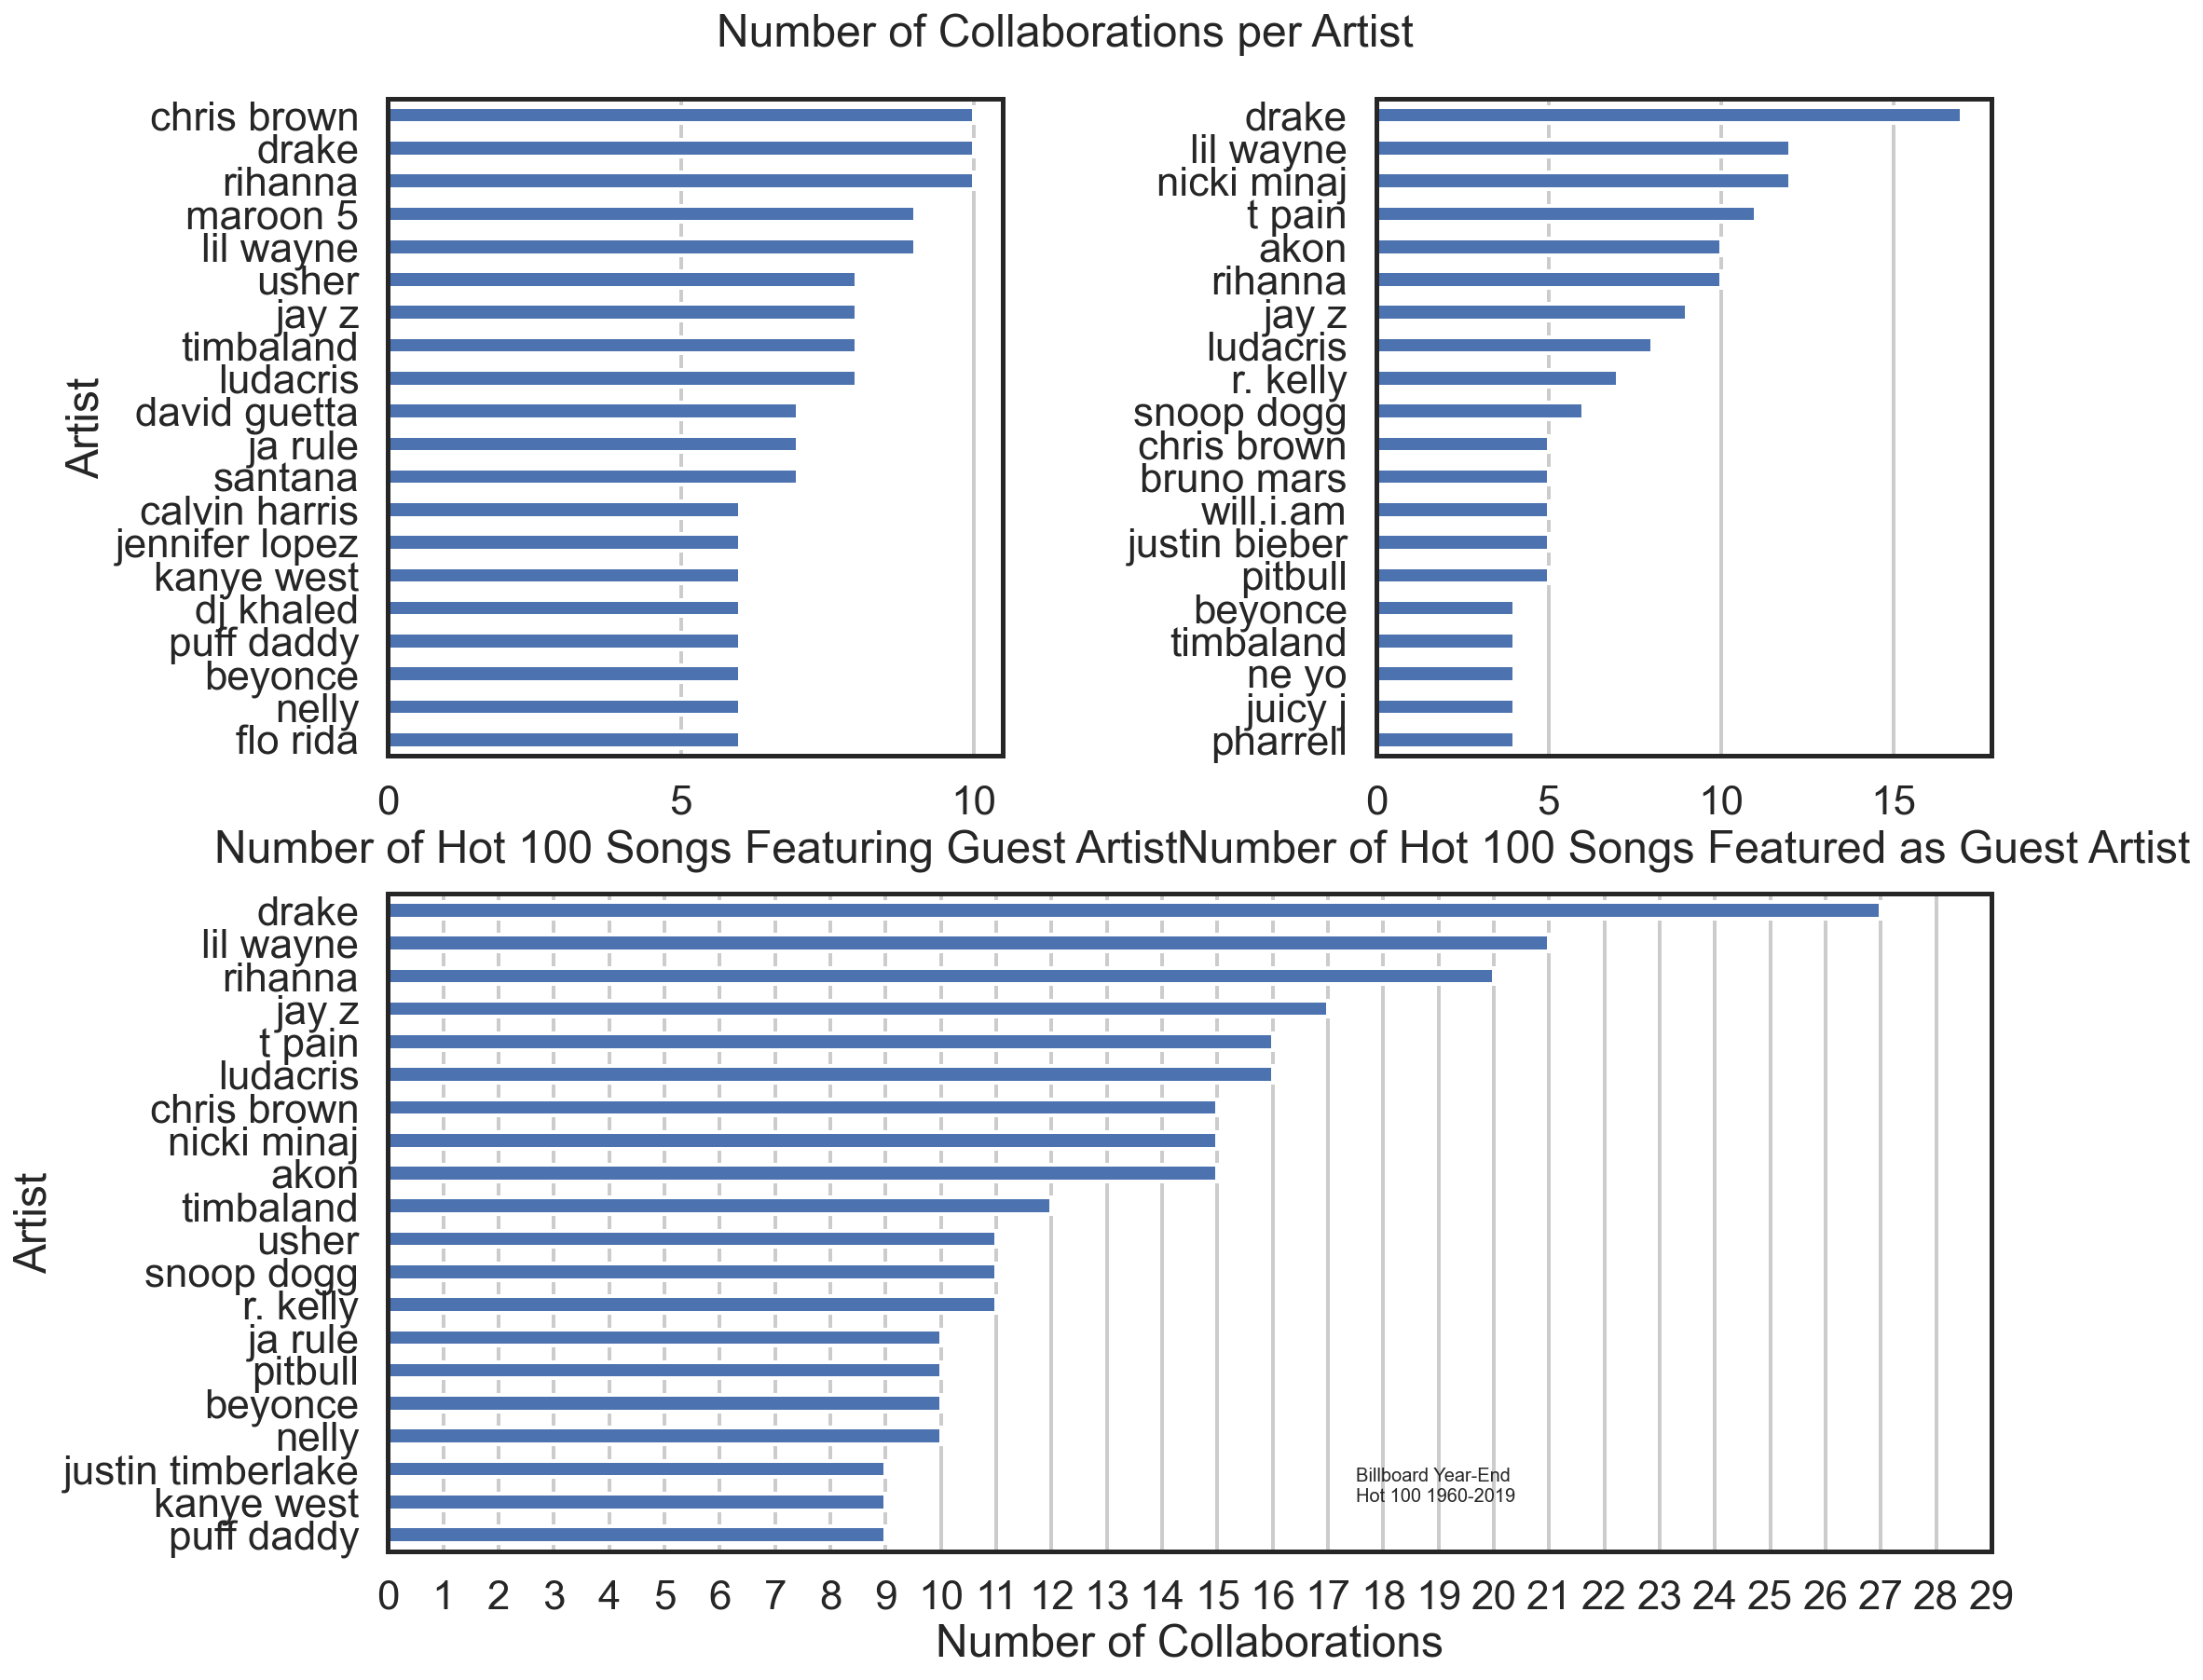

In [6]:
# generate subplots
axes = list()
plt.figure(figsize=(16,12))
grid_positions = [221, 222, 212]
for position in grid_positions:
    axes.append(plt.subplot(position))

    
# calculate "featuring" vs "featured" stats for each artist
featuring_with = df_billboard.groupby('main_artist')['featuring_artist'].count()
featured = df_billboard['featuring_artist'].value_counts()


# generate upper two plots
featuring_with.sort_values().tail(20).plot.barh(ax=axes[0])
featured.sort_values().tail(20).plot.barh(ax=axes[1])
axes[0].set(xlabel='Number of Hot 100 Songs Featuring Guest Artist',
            ylabel='Artist')
axes[1].set(xlabel='Number of Hot 100 Songs Featured as Guest Artist')


# Merge featuring with and featured
featuring_with = featuring_with.reset_index()
featured = featured.reset_index()
merged = pd.merge(featuring_with, featured, how='inner', left_on='main_artist',
                  right_on='index')
merged = merged.drop('index', axis=1)

# calculate total number of collborations from "featuring" and "featured" stats
merged.columns = ['artist', 'n_featuring', 'n_featured']
merged['n_collab'] = merged['n_featuring'] + merged['n_featured']
merged = merged.set_index('artist') # for yticklabels when plotting


# generate lower plot
axes[2] = merged['n_collab'].sort_values().tail(20).plot.barh()
axes[2].set(xlabel='Number of Collaborations', ylabel='Artist')
axes[2].set_xticks(range(0, 30, 1));
axes[2].annotate('Billboard Year-End\nHot 100 1960-2019',
    xy=(17.5,1))

for ax in axes:
    ax.xaxis.grid(True)
plt.tight_layout()
plt.suptitle('Number of Collaborations per Artist', fontsize=24, y=1.04)

## Artist collaboration networks

Text(0.5, 0.98, 'Artist Collaboration Network')

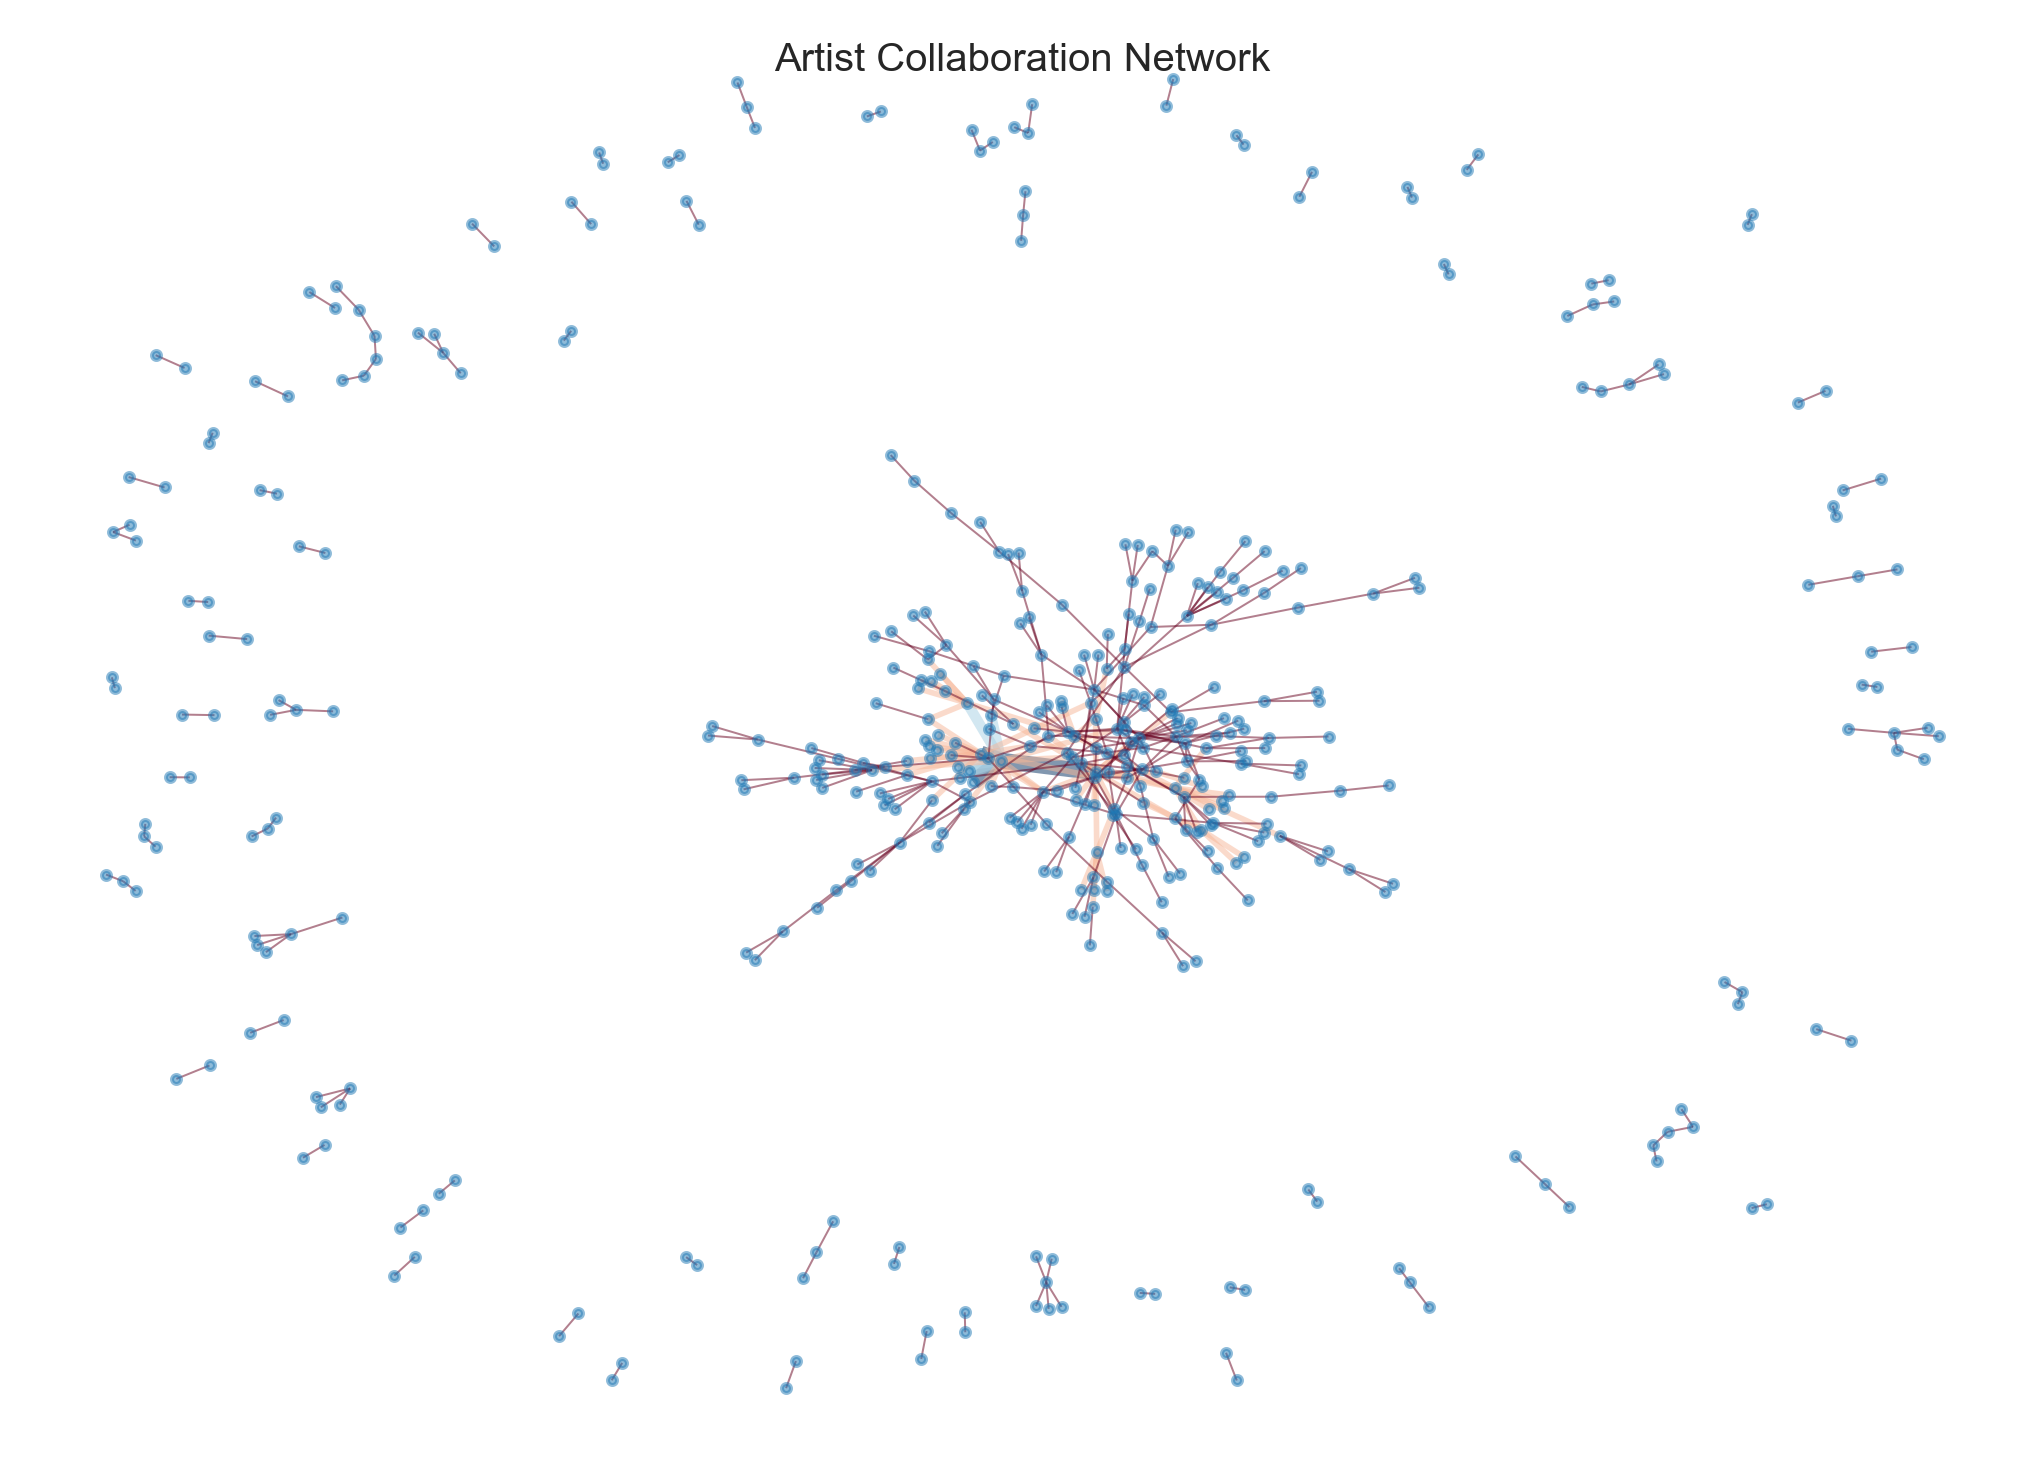

In [7]:
# exclude single-hit artist to simplify network visualization
vc = df_billboard.main_artist.value_counts()
exclude = vc[vc == 1].index

# visualize collaborations as undirected edges weighted by frequency
edges = df_billboard[df_billboard.featuring_artist.notnull()][['main_artist', 'featuring_artist']]
u_edges = list()
for index, row in edges.iterrows():
    artist1 = row['main_artist'].strip()
    artist2 = row['featuring_artist'].strip()
    if artist1 in exclude or artist2 in exclude:
        continue
    # to use groupby to obtain weights, must normalize all artist pairs
    # normalize artist pair by rearranging alphabetically
    new_row = sorted([artist1, artist2])
    u_edges.append(new_row)

# use dummy column of ones and multi-column groupby to obtain edge frequencies
u_edges_df = pd.DataFrame(u_edges)
u_edges_df['dummy'] = 1
u_edges_df = u_edges_df.groupby([0, 1])['dummy'].count().sort_values(ascending=False).reset_index()
u_edges_df.columns = ['artist1', 'artist2', 'degree']

# # generate graph. edge width and color is function of frequency (degrees)
degrees = u_edges_df['degree']
u_edges = u_edges_df[['artist1', 'artist2']].values.tolist()
graph = nx.Graph()
graph.add_edges_from(u_edges)

plt.figure(figsize=(14,10))
nx.draw_spring(graph, node_size=20, edge_color=degrees, edge_cmap=plt.cm.RdBu,
               width=degrees**1.5, alpha=0.5, font_size=15)
plt.suptitle('Artist Collaboration Network', fontsize=20)

Text(0.5, 0.98, 'Artist Collaboration Network: Largest Component')

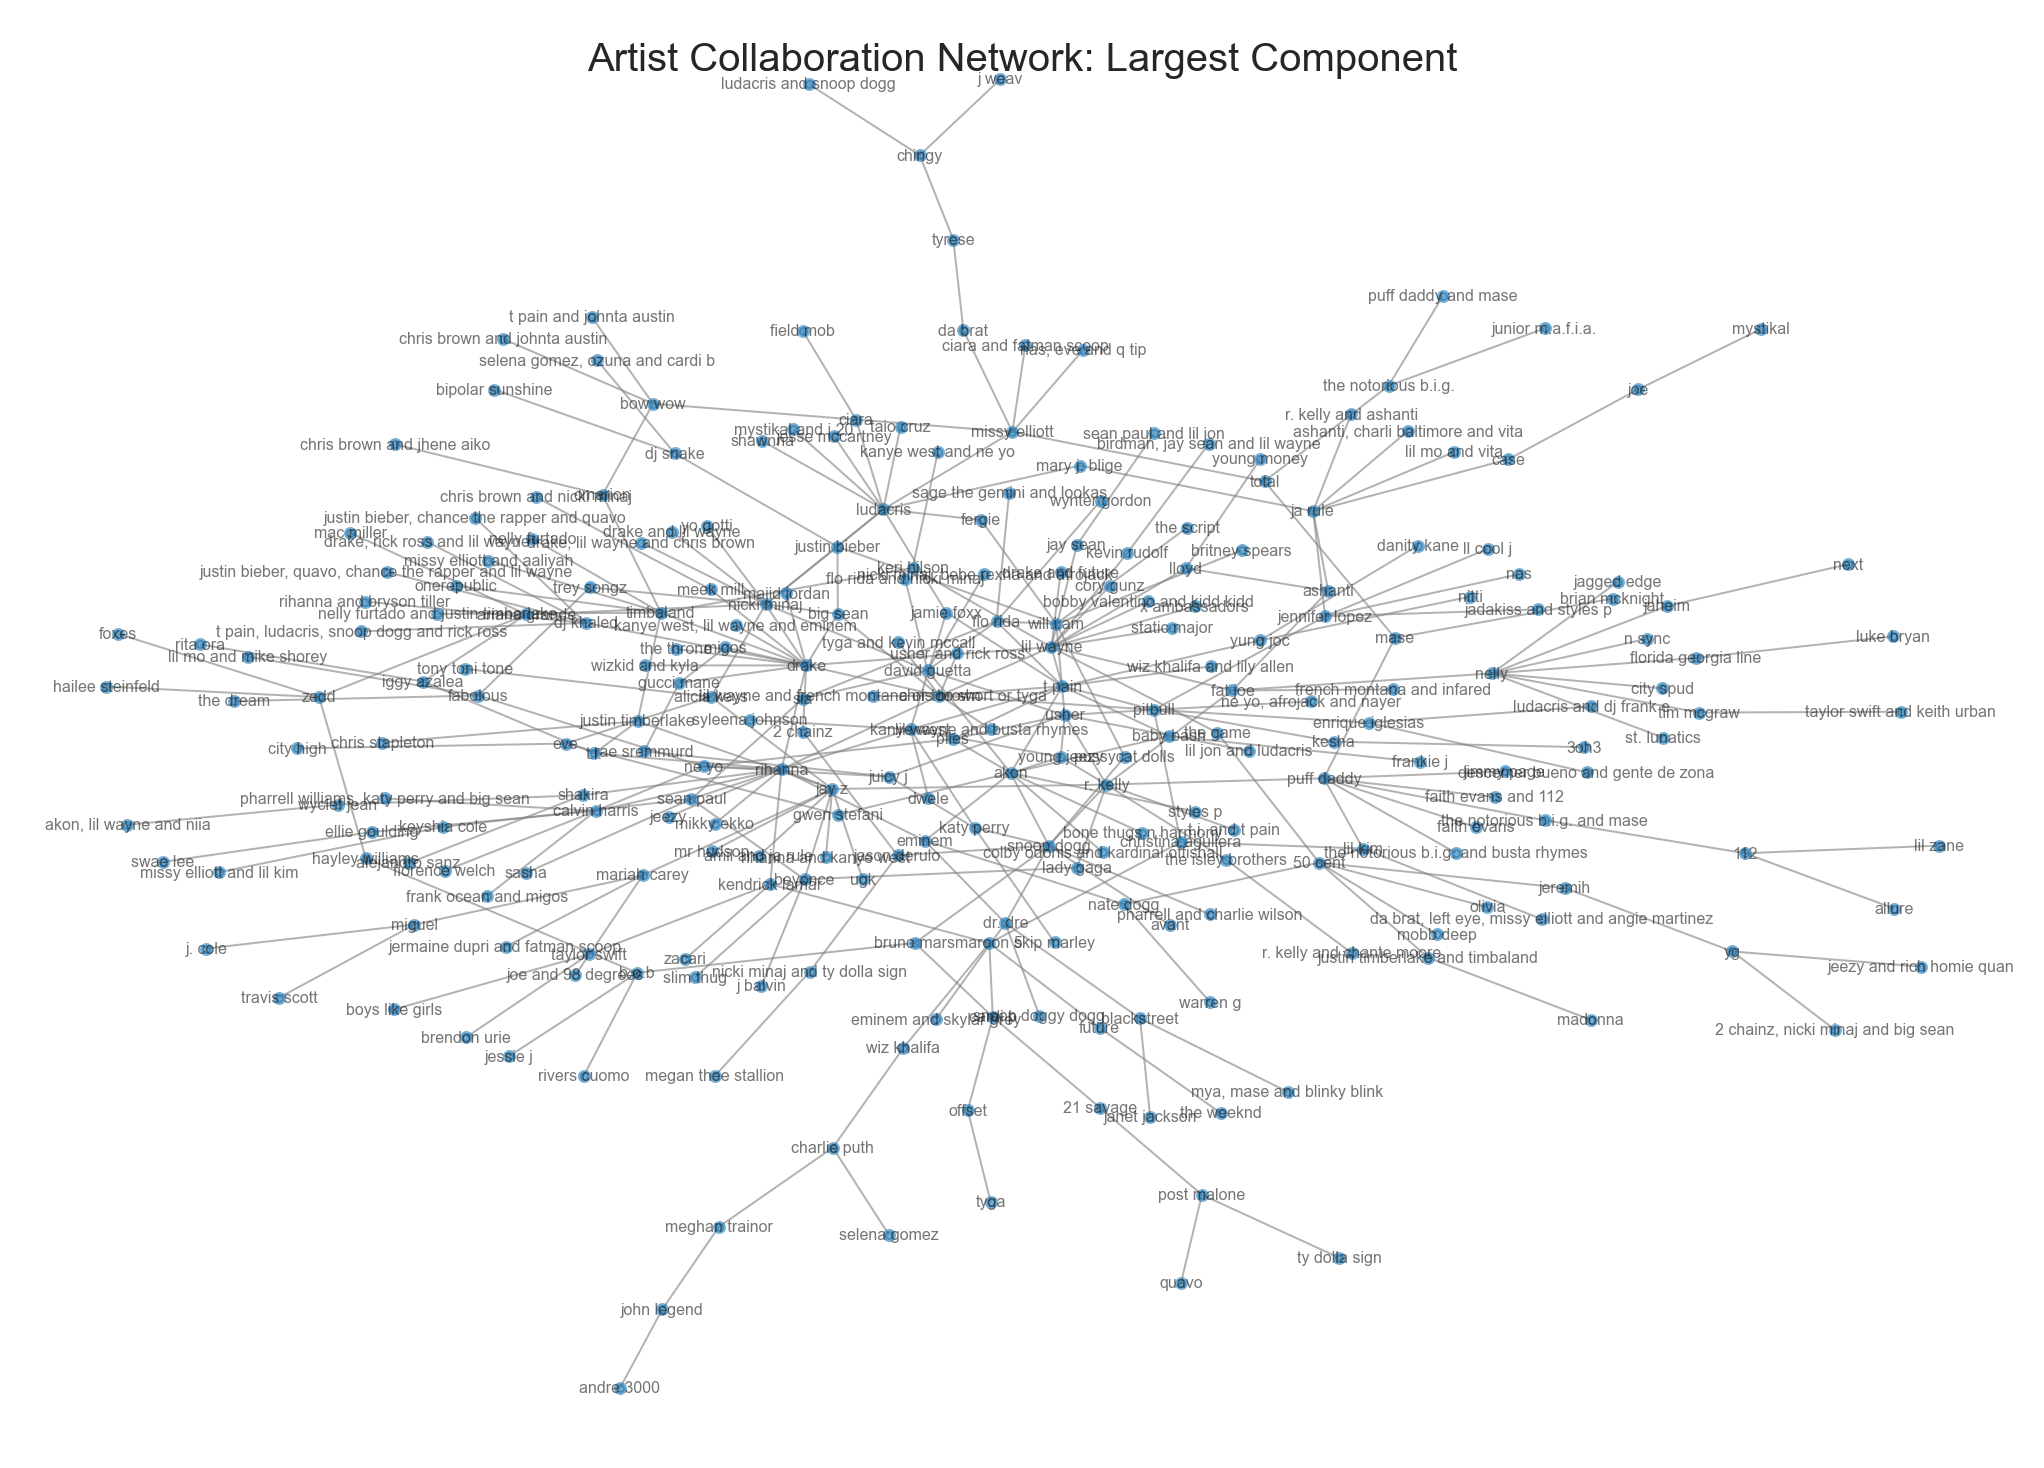

In [8]:
# plot largest component of graph
largest_component_nodes = max(nx.connected_components(graph), key=len)
largest_component_subgraph = graph.subgraph(largest_component_nodes)
plt.figure(figsize=(14,10))
nx.draw_kamada_kawai(largest_component_subgraph, node_size=20, with_labels=True, font_size=8,
                     alpha=0.6, edge_color='gray')
plt.suptitle('Artist Collaboration Network: Largest Component', fontsize=20)


In [9]:
print('total collaborations: {}\n'.format(len(edges)))
u_edges_df[u_edges_df.degree > 1]

total collaborations: 670



,artist1,artist2,degree
0,drake,rihanna,4
1,drake,lil wayne,4
2,beyonce,jay z,4
3,justin timberlake,timbaland,3
4,calvin harris,rihanna,3
...,...,...,...
65,akon,eminem,2
66,3oh3,kesha,2
67,nicki minaj,trey songz,2
68,50 cent,the game,2


## Artist longevity

In [10]:
# artist longevity is difference between year of newest hit and oldest hit + 1
longevity = df_billboard.groupby('main_artist').agg({'year': np.ptp})
longevity.columns = ['longevity']

# keep only 30 artists with longest career spans
longevity = longevity.sort_values(by='longevity', ascending=False).head(30)

# get years for newest and oldest hit
min_max_years = df_billboard.groupby('main_artist')['year'].agg([min, max])

# filter billboard song data for only long-career-span artists
timeless = lambda x: True if x in longevity.index else False
timeless_df = df_billboard[['main_artist', 'year']][df_billboard['main_artist'].apply(timeless)]

Text(0.5, 1.0, 'Artists with Longest Careers')

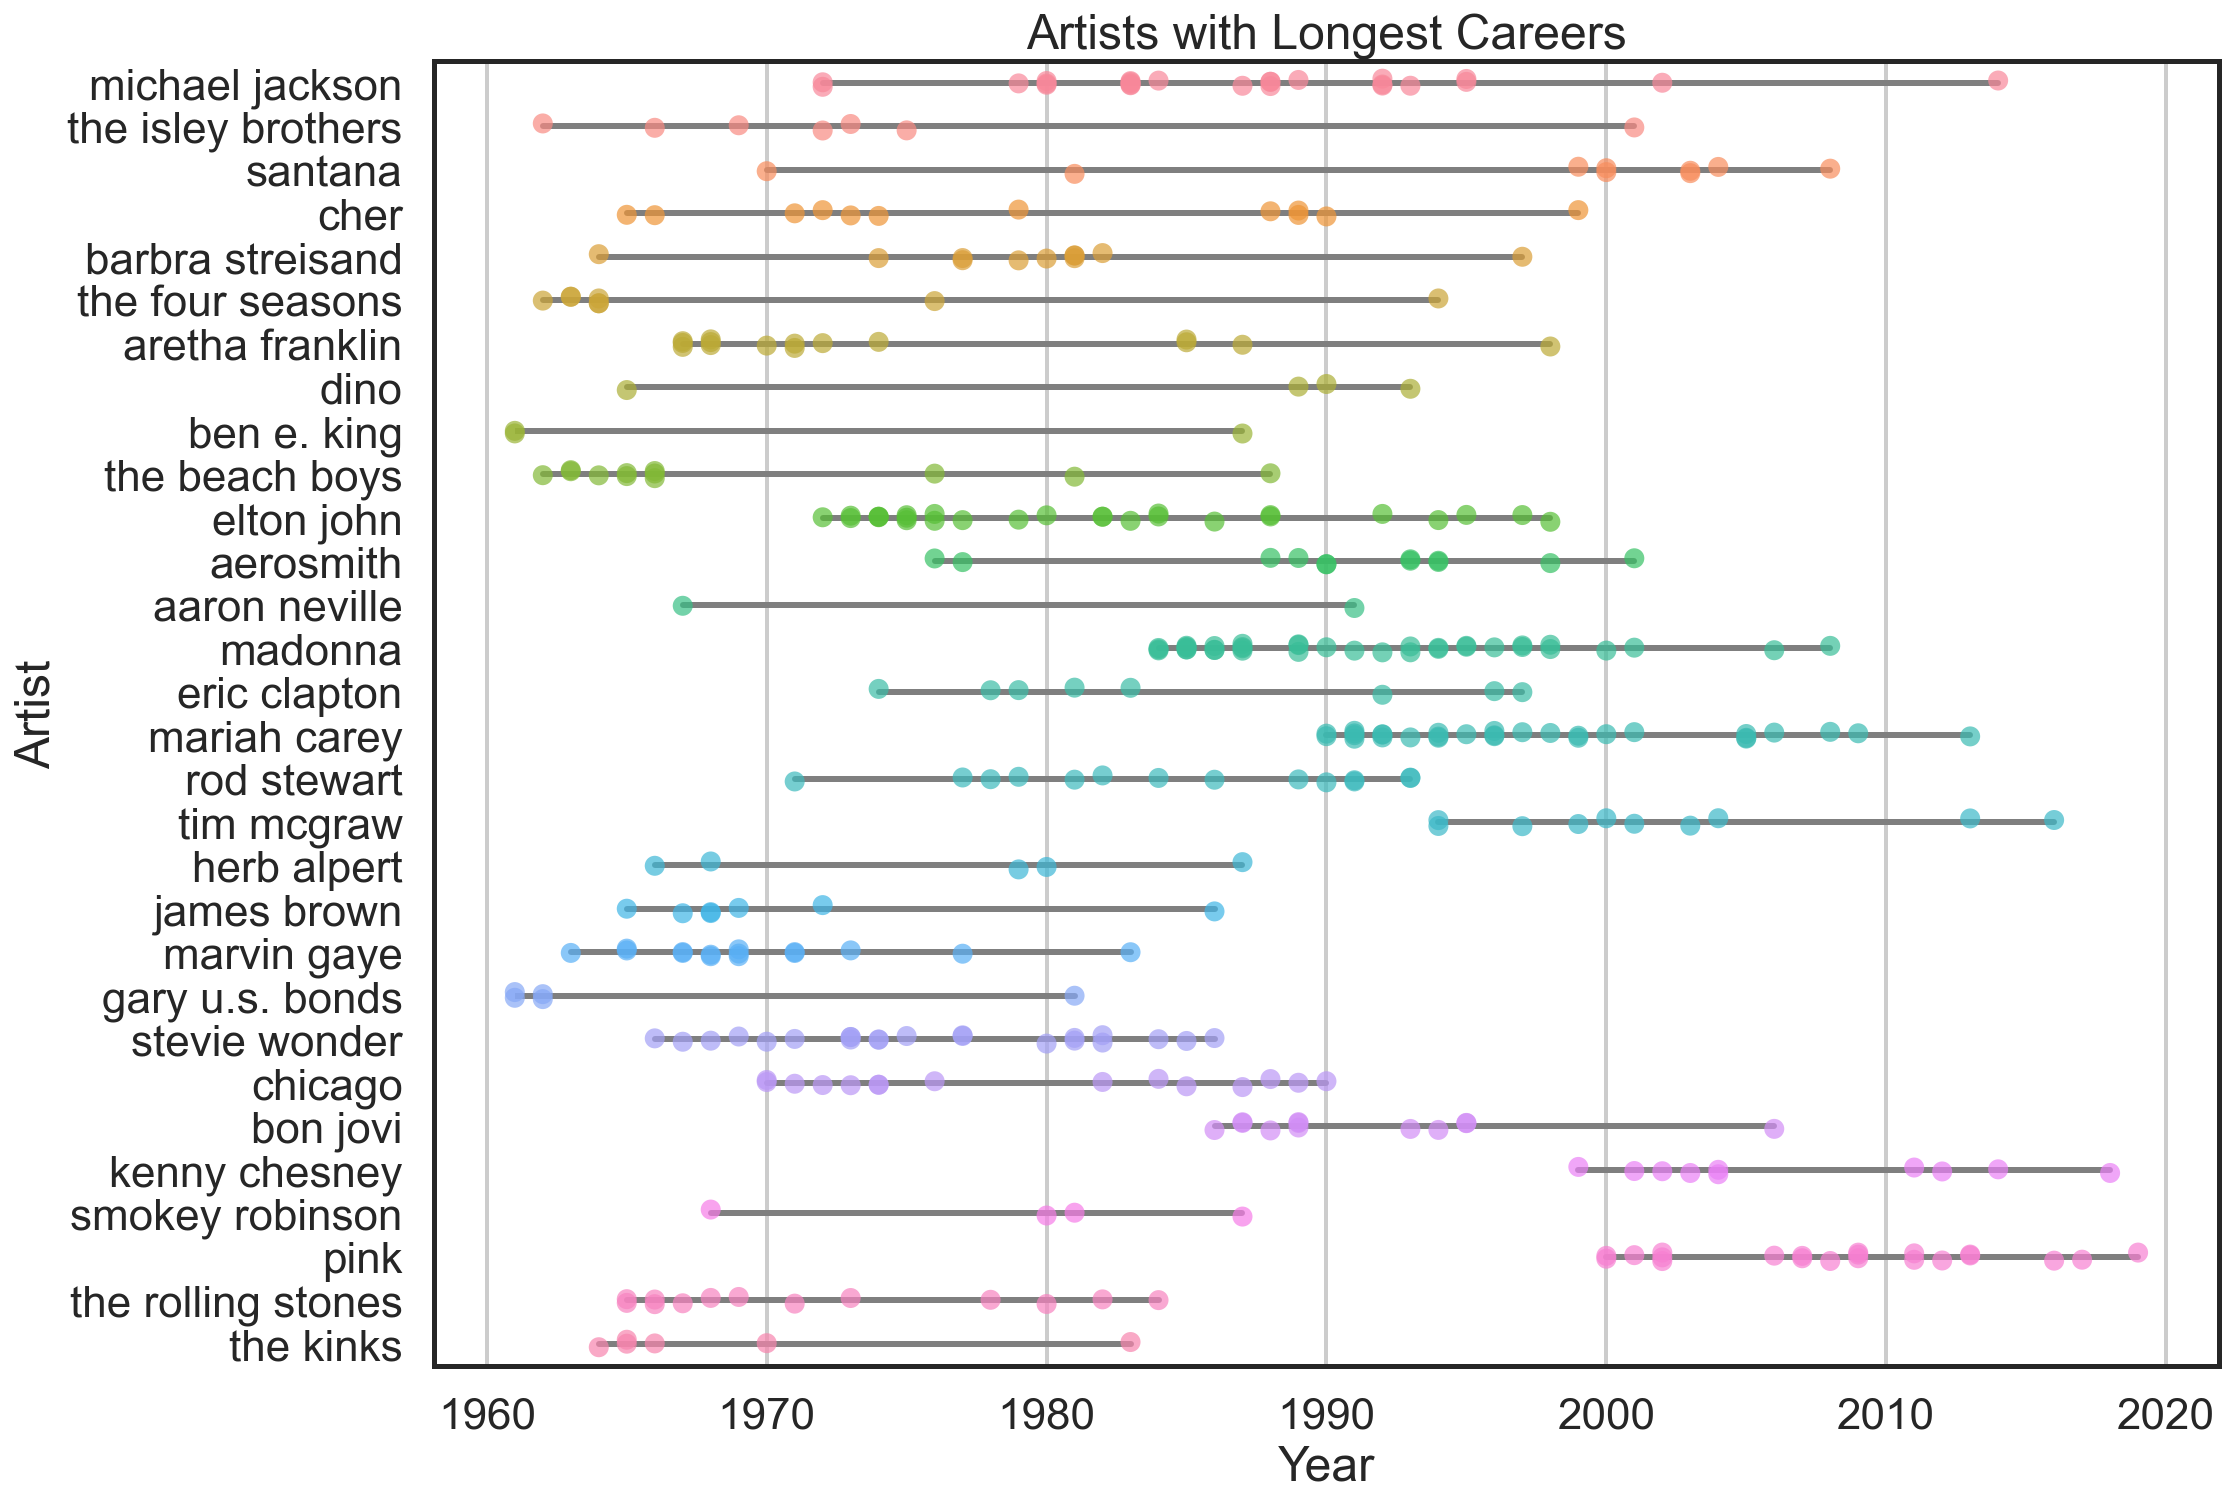

In [11]:
# plot timelines of hits for each artist, ordered by career spans
plt.figure(figsize=(16,12))
ax = sns.stripplot(data=timeless_df, x='year', y='main_artist', jitter=True, 
                   order=longevity.index, size=10, alpha=0.7)
sns.boxplot(data=timeless_df, x='year', y='main_artist', ax=ax, width=0, whis=[0, 100],
            order=longevity.index, color='lightgray')
ax.xaxis.grid(True)
ax.set(ylabel='Artist', xlabel='Year')
ax.set_title('Artists with Longest Careers', fontsize=24)

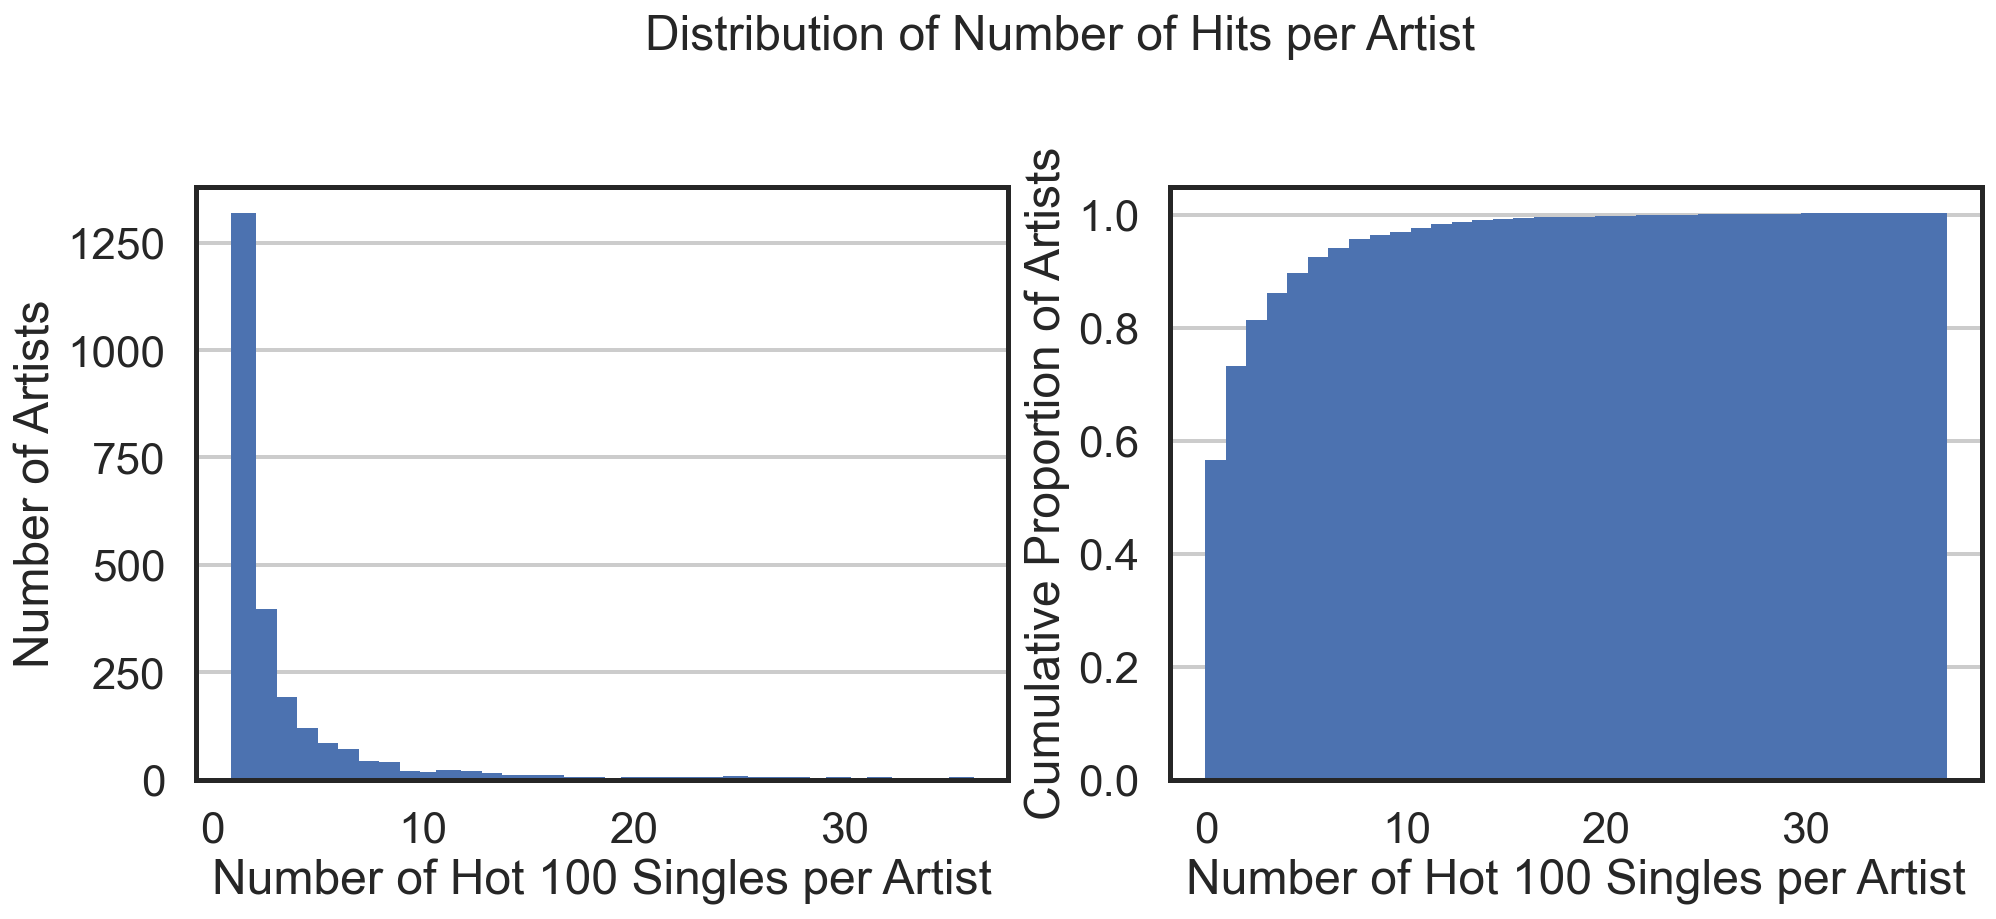

In [12]:
# generate subplots
axes = list()
plt.figure(figsize=(16,12))
grid_positions = [221, 222]
for position in grid_positions:
    axes.append(plt.subplot(position))

# generate upper left histogram
df_billboard['main_artist'].value_counts().plot.hist(bins=36, ax=axes[0], alpha=1, width=1,
                                                     edgecolor='C0')
axes[0].set(ylabel='Number of Artists')

# generate upper right cumulative relative frequency histogram
counts = df_billboard['main_artist'].value_counts()
res = relfreq(counts, numbins=36)
x = res.lowerlimit + np.linspace(0, res.binsize*res.frequency.size,
                                 res.frequency.size)
axes[1].bar(x, np.cumsum(res.frequency), width=res.binsize - 0.04, alpha=1, edgecolor='C0')
axes[1].set(ylabel = 'Cumulative Proportion of Artists')

for ax in axes[:2]:
    ax.set(xlabel='Number of Hot 100 Singles per Artist')
    ax.yaxis.grid(True)

plt.suptitle('Distribution of Number of Hits per Artist',
             fontsize=24);